Importing the Libraries to perform the classification

In [2]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

Loading the Directory where the images are stored

In [3]:
PATH =os.getcwd()+'/COVID-19_Radiography_Dataset'

In [4]:
os.listdir(PATH)

['.DS_Store', 'Viral Pneumonia', 'Lung_Opacity', 'Normal', 'COVID']

Creating our Datasets for the analysis purpose

In [5]:
# Image generator for training (includes data augmentation)
imgTrainGen = tf.keras.preprocessing.image.ImageDataGenerator(
    samplewise_center=True, #Set each sample mean to 0.
    samplewise_std_normalization= True, # Divide each input by its standard deviation]
    rescale=1./255, 
    zoom_range = 0.2, 
    validation_split = 0.2  
)

# Image generator for Validation (didn't include augmentation)
imgValidGen = tf.keras.preprocessing.image.ImageDataGenerator(
    samplewise_center=True, #Set each sample mean to 0.
    samplewise_std_normalization= True,
    rescale=1./255,
    validation_split = 0.2
)

# Image generator for testing (didn't include augmentation)
imgTestGen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split = 0.2
)
# Build for training
trainGeneratorBuild = imgTrainGen.flow_from_directory(
    PATH,
    subset = 'training',
    target_size = (224, 224),
    class_mode = 'categorical',
    batch_size = 32,
    shuffle= True
)
# Build for validation
validGeneratorBuild = imgValidGen.flow_from_directory(
    PATH,
    subset = 'validation',
    target_size = (224, 224),
    class_mode = 'categorical',
    batch_size = 32,
    shuffle=True
)
# Build for testing
testGeneratorBuild = imgTestGen.flow_from_directory(
    PATH,
    subset = 'validation',
    target_size = (224, 224),
    class_mode = 'categorical',
    batch_size = 32,
    shuffle=True
)

Found 16933 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.


Creating the VGG16 Model

In [13]:
from tensorflow.keras.applications.vgg16 import VGG16

In [14]:
base_model = VGG16(input_shape = (224, 224, 3),# Shape of our images
                   include_top = False, # Leave out the last fully connected layer i.e. only use the last layer for training
weights = 'imagenet')

2021-11-13 20:25:58.671509: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-13 20:25:58.672336: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [15]:
for layer in base_model.layers:
    layer.trainable = False

In [16]:
from tensorflow.keras import Model

In [ ]:

x= base_model.output
x=GlobalAveragePooling2D()(x)
x= Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
out =layers.Dense(4, activation='softmax')(x)


# Creating our model
model = Model(inputs=base_model.input, outputs=out)

model.summary()


In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
 early_stop = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               patience = 5 ,
                               restore_best_weights=True)

Setting our Checkpoint for finding the best fit from epoch and save it in h5 format

In [20]:
 mc = ModelCheckpoint('vgg16_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [21]:

history=model.fit(trainGeneratorBuild,batch_size=32, epochs=10, validation_data=validGeneratorBuild,callbacks = [early_stop,mc],verbose=1)

2021-11-13 20:26:09.941209: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-13 20:26:09.942250: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-11-13 20:26:10.126666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/10
530/530 [==============================] - ETA: 0s - loss: 0.6291 - accuracy: 0.7581

2021-11-13 20:30:48.441342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


530/530 [==============================] - 349s 657ms/step - loss: 0.6291 - accuracy: 0.7581 - val_loss: 0.4102 - val_accuracy: 0.8537

Epoch 00001: val_loss improved from inf to 0.41022, saving model to vgg16_model.h5
Epoch 2/10
530/530 [==============================] - 421s 794ms/step - loss: 0.4428 - accuracy: 0.8365 - val_loss: 0.3653 - val_accuracy: 0.8684

Epoch 00002: val_loss improved from 0.41022 to 0.36528, saving model to vgg16_model.h5
Epoch 3/10
530/530 [==============================] - 1304s 2s/step - loss: 0.4035 - accuracy: 0.8499 - val_loss: 0.4357 - val_accuracy: 0.8462

Epoch 00003: val_loss did not improve from 0.36528
Epoch 4/10
530/530 [==============================] - 380s 717ms/step - loss: 0.3798 - accuracy: 0.8592 - val_loss: 0.3696 - val_accuracy: 0.8665

Epoch 00004: val_loss did not improve from 0.36528
Epoch 5/10
530/530 [==============================] - 398s 750ms/step - loss: 0.3602 - accuracy: 0.8691 - val_loss: 0.3486 - val_accuracy: 0.8762

Epoch 

Calculation overall Train and Validation Score.

In [22]:
print("Train score:", model.evaluate(trainGeneratorBuild))
print("Validation score:", model.evaluate(validGeneratorBuild))
n_epochs = len(history.history['loss'])

530/530 [==============================] - 370s 698ms/step - loss: 0.2821 - accuracy: 0.8936
Train score: [0.28210750222206116, 0.8936396241188049]
133/133 [==============================] - 90s 672ms/step - loss: 0.3362 - accuracy: 0.8828
Validation score: [0.33615654706954956, 0.8827977776527405]


Plotting:
1. Train and Validation Loss.
2. Train and Validation Accuracy.

In [23]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig, ax = plt.subplots(1,2,figsize=(20,10))
  ax[0].plot(epochRange,history.history['accuracy'],'b',label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],'r',label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch', fontsize = 20)
  ax[0].set_ylabel('Accuracy', fontsize = 20)
  ax[0].legend()
  ax[0].grid(color='gray', linestyle='--')
  ax[1].plot(epochRange,history.history['loss'],'b',label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],'r',label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch', fontsize = 20)
  ax[1].set_ylabel('Loss', fontsize = 20)
  ax[1].legend()
  ax[1].grid(color='gray', linestyle='--')
  plt.show()

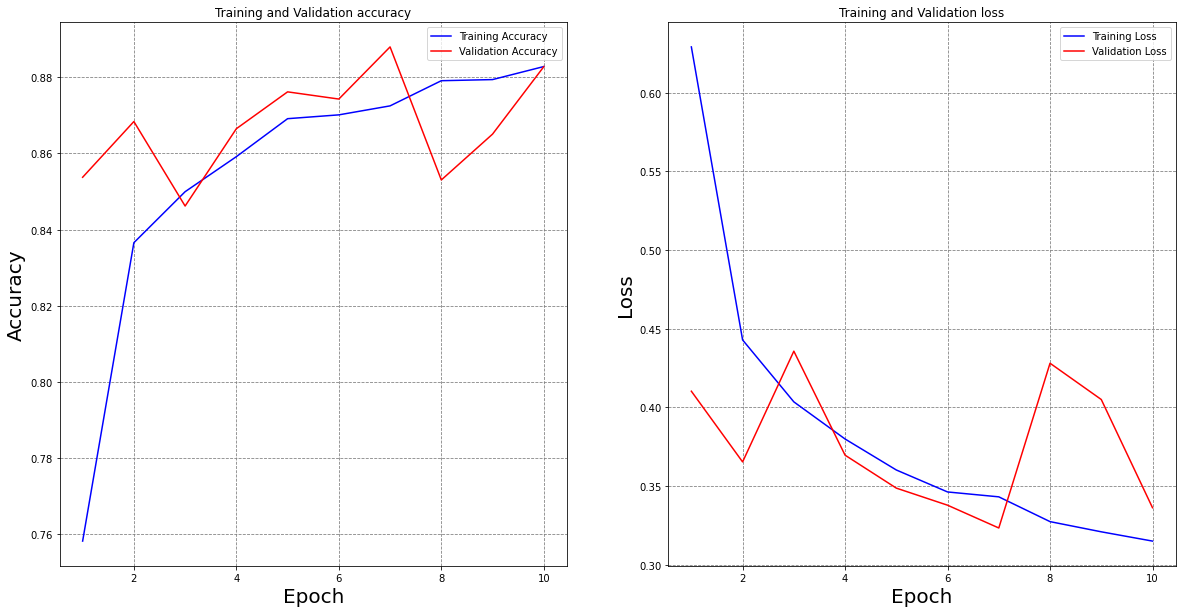

In [24]:
plotLearningCurve(history,n_epochs)

In [27]:
from tensorflow.keras.preprocessing import image

def get_img_array(img_path):
  """
  Input : Takes in image path as input 
  Output : Gives out Pre-Processed image
  """
  path = img_path
  img = image.load_img(path, target_size=(224,224,3))
  img = image.img_to_array(img)
  img = np.expand_dims(img , axis= 0 )
  
  return img

2021-11-13 22:04:43.682935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


The given X-Ray image is of type = Normal

The chances of image being Covid is : 0.0 percent

The chances of image being Lung_Opacity is : 0.0 percent

The chances of image being Normal is : 100.0 percent

The chances of image being Viral Pneumonia is : 0.0 percent


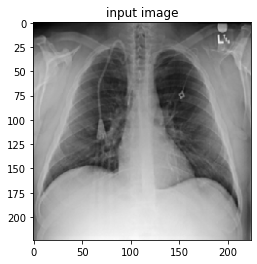

In [28]:
# path for that new image.
PATH =os.getcwd()+'/COVID-19_Radiography_Dataset/Normal/Normal-5.png'
class_names=['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
# you can add any image path
img = get_img_array(PATH)

res = class_names[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Lung_Opacity is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][2]*100} percent")
print()
print(f"The chances of image being Viral Pneumonia is : {model.predict(img)[0][3]*100} percent")



# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()